In [1]:
import pandas
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pandas.read_csv("./prices-split-adjusted.csv",index_col = 0)

In [4]:
df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [ ]:
[x for x in df.symbol if x == "NVDA"]

In [3]:
price = df[df.symbol=="NVDA"]["close"]

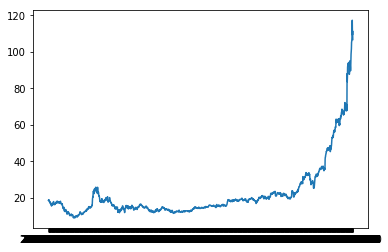

In [5]:
plt.plot(price)